In [1]:
import os

import pandas as pd
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import re
import spacy

import warnings
warnings.filterwarnings("ignore")

In [2]:
basic_path = 'crisis_datasets_benchmarks_v1.0/data/all_data_en/'

In [3]:
file_names = os.listdir(basic_path)

In [4]:
file_names

['crisis_consolidated_humanitarian_filtered_lang_en_dev.tsv',
 'crisis_consolidated_humanitarian_filtered_lang_en_test.tsv',
 'crisis_consolidated_humanitarian_filtered_lang_en_train.tsv',
 'crisis_consolidated_informativeness_filtered_lang_en_dev.tsv',
 'crisis_consolidated_informativeness_filtered_lang_en_test.tsv',
 'crisis_consolidated_informativeness_filtered_lang_en_train.tsv']

In [5]:
def process_csv_files(input_files):
    # Create an empty DataFrame to store the data
    df_combined = pd.DataFrame()

    # Iterate through the list of input file names
    for file_name in input_files:
        file_path = os.path.join(basic_path, file_name)

        try:
            df = pd.read_csv(file_path, sep='\t')
            df_combined = pd.concat([df_combined, df], ignore_index=True)
        except (pd.errors.ParserError, pd.errors.EmptyDataError) as e:
            print(f"Error reading file {file_name}: {e}. Skipping problematic rows.")

            # Read the file again, skipping problematic rows
            df_part1 = pd.read_csv(file_path, sep='\t', nrows=31027)
            df_part2 = pd.read_csv(file_path, sep='\t', skiprows=range(1, 31029))
            df_combined = pd.concat([df_combined, df_part1, df_part2], ignore_index=True)

    return df_combined

In [6]:
df_humanitarian = process_csv_files(file_names[:3])

In [7]:
df_informativeness = process_csv_files(file_names[3:])

Error reading file crisis_consolidated_informativeness_filtered_lang_en_test.tsv: Error tokenizing data. C error: EOF inside string starting at row 31028. Skipping problematic rows.


In [8]:
df_all = pd.concat([df_humanitarian, df_informativeness], ignore_index=True)

In [9]:
df_all['event'].value_counts()

event
disaster_events                      48718
2015_nepal_earthquake                20649
2013_oklahoma_tornado-ontopic        13768
2013_alberta_floods-ontopic          13256
2014_philippines_typhoon-hagupit     13040
                                     ...  
2012_italy_earthquakes                 202
2014_malaysia_airline                  197
2013_italy_sardinia                    117
2012_venezuela_refinery-explosion      114
2014_chile_earthquake_esp                1
Name: count, Length: 61, dtype: int64

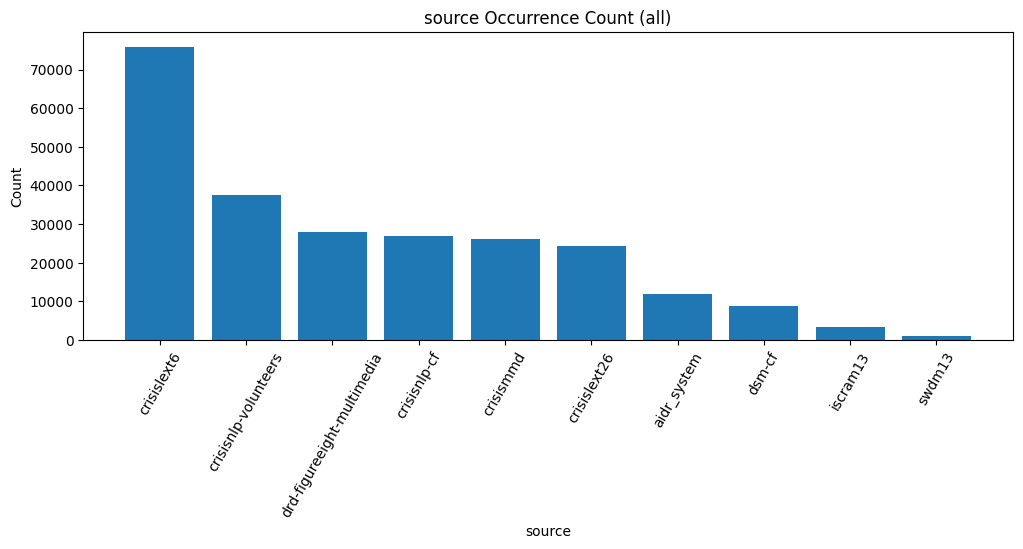

In [10]:
# Create a histogram
plt.figure(figsize=(12, 4)) 

source_counts_all = df_all['source'].value_counts()

plt.bar(source_counts_all.index, source_counts_all.values)

# Customize the plot
plt.title('source Occurrence Count (all)')
plt.xlabel('source')
plt.xticks(rotation=60)
plt.ylabel('Count')

# Display the histogram
plt.show()

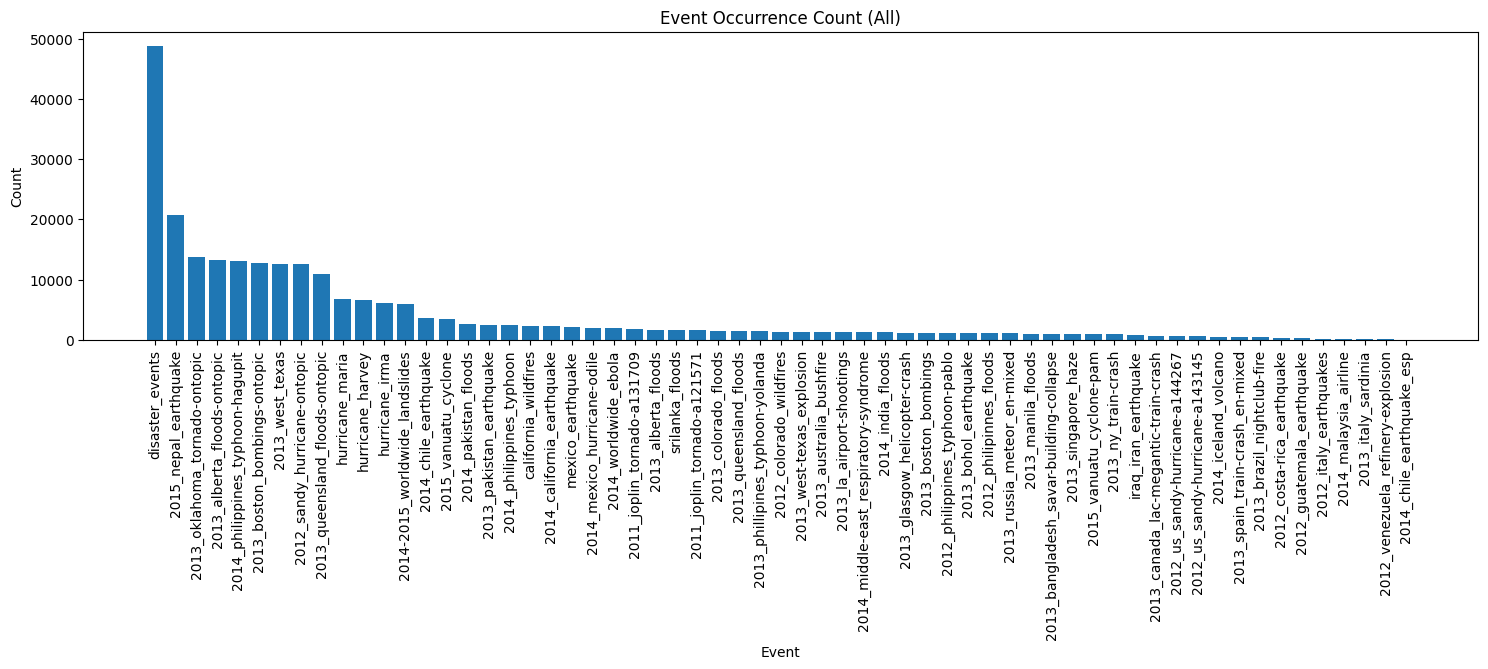

In [11]:
# Create a histogram
plt.figure(figsize=(18, 4)) 

event_counts_all = df_all['event'].value_counts()

plt.bar(event_counts_all.index, event_counts_all.values)

# Customize the plot
plt.title('Event Occurrence Count (All)')
plt.xlabel('Event')
plt.xticks(rotation=90)
plt.ylabel('Count')

# Display the histogram
plt.show()

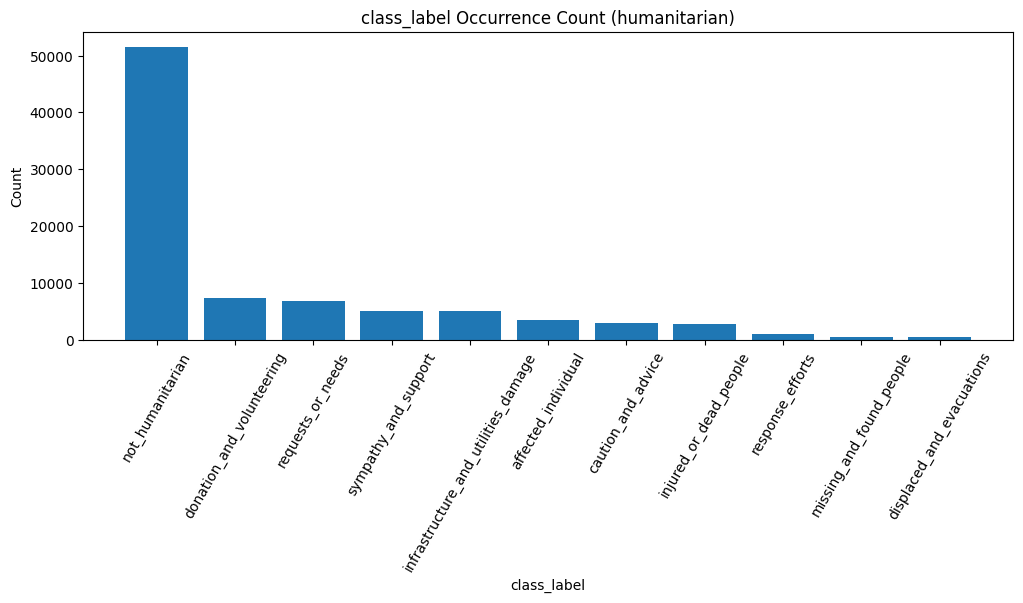

In [12]:
# Create a histogram
plt.figure(figsize=(12, 4)) 

event_counts_h = df_humanitarian['class_label'].value_counts()


plt.bar(event_counts_h.index, event_counts_h.values)

# Customize the plot
plt.title('class_label Occurrence Count (humanitarian)')
plt.xlabel('class_label')
plt.xticks(rotation=60)
plt.ylabel('Count')

# Display the histogram
plt.show()

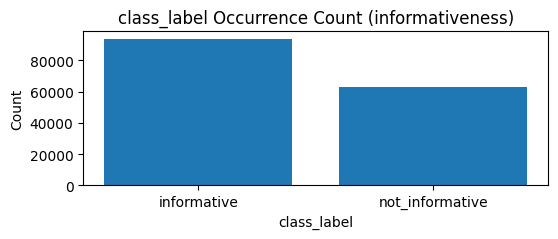

In [13]:
# Create a histogram
plt.figure(figsize=(6, 2)) 

event_counts_i = df_informativeness['class_label'].value_counts()

plt.bar(event_counts_i.index, event_counts_i.values)

# Customize the plot
plt.title('class_label Occurrence Count (informativeness)')
plt.xlabel('class_label')
# plt.xticks(rotation=60)
plt.ylabel('Count')

# Display the histogram
plt.show()

In [14]:
df_humanitarian['class_label'].unique()

array(['not_humanitarian', 'infrastructure_and_utilities_damage',
       'sympathy_and_support', 'donation_and_volunteering',
       'injured_or_dead_people', 'requests_or_needs', 'response_efforts',
       'missing_and_found_people', 'caution_and_advice',
       'affected_individual', 'displaced_and_evacuations'], dtype=object)

In [15]:
df_needs = df_humanitarian[df_humanitarian['class_label'] == 'requests_or_needs']

In [16]:
def extract_geo_entities(text):
    doc = nlp(text)
    geo_entities = [ent.text for ent in doc.ents if ent.label_ == "GPE"]
    return geo_entities

In [17]:
nlp = spacy.load("en_core_web_lg")

df_needs["geo_entities"] = df_needs["text"].apply(extract_geo_entities)
df_needs["geo_entities"] = df_needs["geo_entities"].apply(lambda x: None if len(x) == 0 else x)

In [47]:
key_entity_types = ["GPE"]

key_words_list_all = []

for text in df_all['text']:
    text = text.lower()
    doc = nlp(text)
    keywords = [ent.text for ent in doc.ents if ent.label_ in key_entity_types]
    key_words_list_all.extend(keywords)

In [42]:
# key_word_df = pd.DataFrame({'word': key_words_list_all})
# key_word_df = key_word_df[(key_word_df['word'] != 'None') & (key_word_df['word'] != 'none')]

# word_counts = key_word_df['word'].value_counts().reset_index()

# word_counts.columns = ['word', 'count']
# word_counts

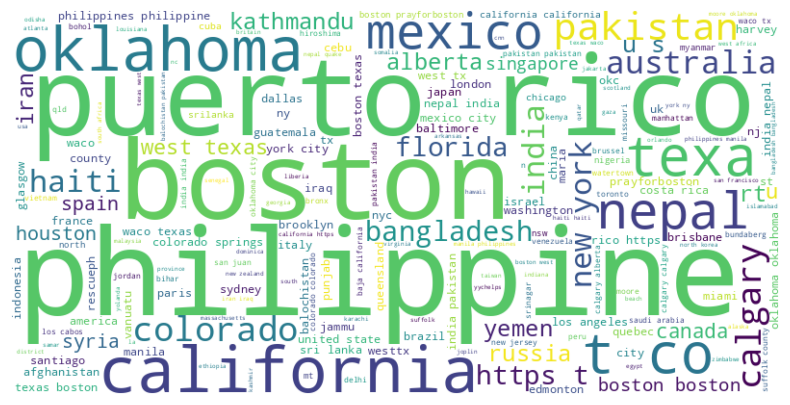

In [48]:
combined_text = ' '.join(key_words_list_all)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()